<h1>Определение стоимости автомобилей</h1>

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости.
Заказчику важны: качество предсказания; скорость предсказания; время обучения.

**Описание данных**

*Признаки*:

    - DateCrawled — дата скачивания анкеты из базы
    - VehicleType — тип автомобильного кузова
    - RegistrationYear — год регистрации автомобиля
    - Gearbox — тип коробки передач
    - Power — мощность (л. с.)
    - Model — модель автомобиля
    - Kilometer — пробег (км)
    - RegistrationMonth — месяц регистрации автомобиля
    - FuelType — тип топлива
    - Brand — марка автомобиля
    - NotRepaired — была машина в ремонте или нет
    - DateCreated — дата создания анкеты
    - NumberOfPictures — количество фотографий автомобиля
    - PostalCode — почтовый индекс владельца анкеты (пользователя)
    - LastSeen — дата последней активности пользователя

*Целевой признак*:

    - Price - цена

**План работы**: первым делом мы загрузим и изучим данные, проведем предобработку; затем - обучим разные модели, и наконец, оценим их качество и скорость работы.

<h3>Оглавление</h3>

1. [Шаг 1: Знакомство с данными](#samples)
2. [Шаг 2: Исследовательский анализ](#res)
3. [Шаг 3: Предобработка данных](#preproc)
4. [Шаг 4: Обучение моделей](#models)
5. [Шаг 5: Выводы и выбор лучшией модели](#test_sanity)

<h3>Шаг 1: Знакомство с данными</h3>
<a id='samples'></a>

Первым делом импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from copy import deepcopy
import warnings
warnings.filterwarnings(action='ignore')

Загрузим и изучим данные.

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


**Вывод по Шагу 1**: данных много - это плюс, а теперь к минусам - во-первых, пропуски, во-вторых, некорректные и аномальные значения, которые видно уже с первых пяти строк - 0 лошадиных сил, 0 месяц регистрации, в-третьих, типы данных дат - object, а не типы данных, предназначенные для дат.

<h3>Шаг 2: Исследовательский анализ</h3>
<a id='res'></a>

Рассмотрим данные поближе. Начнем с дат.

**DateCrawled**

Данный столбец содержит дату скачивания анкеты из базы. Нетрудно убедиться, что диапазон месяцов в данном столбце 3-4 (анкеты скачивались в марте и апреле), а год везде один - 2016. 

Перед этим превратим столбец в тип datetime.

In [5]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])

Минимум.

In [6]:
data.DateCrawled.dt.date.min()

datetime.date(2016, 3, 5)

Максимум.

In [7]:
data.DateCrawled.dt.date.max()

datetime.date(2016, 4, 7)

Можно сделать вывод, что данный столбец не несет в себе ценной информации. Кандидат на удаление.

**LastSeen**

Данный столбец содержит даты последней активности пользователя.

In [8]:
data['LastSeen'] = pd.to_datetime(data['LastSeen'])

Также оценим минимум и максимум.

In [9]:
data.LastSeen.dt.date.min()

datetime.date(2016, 3, 5)

In [10]:
data.LastSeen.dt.date.max()

datetime.date(2016, 4, 7)

Опять же - значения близки, помимо этого - совпадают с теми, что получены при исследовании столбца, содержащего даты скачивания анкет.

Посмотрим на последний столбец с датой.

**DateCreated**

In [11]:
data['DateCreated'] = pd.to_datetime(data['DateCreated'])

In [12]:
data.DateCreated.dt.date.min()

datetime.date(2014, 3, 10)

In [13]:
data.DateCreated.dt.date.max()

datetime.date(2016, 4, 7)

Здесь ситуация уже интереснее - некоторые анкеты создавались достаточно давно.

Какой вывод можно сделать по всем трем столбцам? По сути, они не особо полезны. Дата скачивания анкеты, создания анкеты и дата последней активности пользователя не оказывают очевидного влияния на цену авто. Как можно поступить в данной ситуации? Извлечь из этих признаков новый - количество дней пользователя на сайте. Чем больше это число, тем дольше продается автомобиль. Но здесь есть некоторые нюансы:

    - некоторые анкеты совсем новые, и даже если они совсем неудачные, то не будут обнаружены как выделяющиеся => получим равенство пользователей, которые продали машину за 15 дней, и тех, что просто зарегистрировались 15 дней назад (очевидно, данные о последней активности снимались примерно в то же время, что и загружались анкеты), 
    - автомобили могут быть просто весьма на любителя, это не значит, что тут что-то не так (читайте: слишком высокая цена)

Оптимальный вариант здесь: создать такой признак, опираясь на него удалить аномалии, а затем - не использовать его.

Посмотрим на категориальные признаки.

**VehicleType**

Посмотрим, какие типы автомобильного кузова бывают в наших данных.

In [14]:
data['VehicleType'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

Все выглядит хорошо. Но вообще - если заглянуть, что за объявления лежат под other, можно заметить весьма стандартные модели машин. Непонятно - то ли это действительно какие-то новинки, то ли некорректные значения. Попытка выяснить этот вопрос привела к тому, что у некоторых машин вообще написано везде по-разному.

In [15]:
data[(data.Model == 'golf') & (data.Brand == 'volkswagen')].VehicleType.unique()

array([nan, 'small', 'sedan', 'bus', 'other', 'wagon', 'convertible',
       'coupe', 'suv'], dtype=object)

Вот такой вот фольксваген.

Пока непонятно, что с этим делать.

**GearBox**

In [16]:
data.Gearbox.value_counts()

manual    268251
auto       66285
Name: Gearbox, dtype: int64

Все супер.

**Model**

In [17]:
data.Model.nunique()

250

In [18]:
data.Model.value_counts().head(10)

golf        29232
other       24421
3er         19761
polo        13066
corsa       12570
astra       10809
passat      10146
a4           9900
c_klasse     8312
5er          7868
Name: Model, dtype: int64

На 350000 тысяч объявлений всего 250 моделей (большее разнообразие, по всей видимости, под категорией other), очевидно, есть наиболее часто встречающиеся - и на них мы тоже глянули. 

**FuelType**

In [19]:
data.FuelType.value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

Очень интересно, что скрывается под other. Среди объявлений, машины в которых ездят на ОСОБОМ топливе, можно найти и ауди а3 и форд фокус, интересно.

Данная ситуация ставит в такой же ступор, как и фольксваген двумя пунктами выше.

**Brand**

In [20]:
data.Brand.value_counts()

volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: Brand, dtype: int64

Все супер, даже Лада есть!

**NotRepaired**

In [21]:
data.NotRepaired.value_counts()

no     247161
yes     36054
Name: NotRepaired, dtype: int64

Порядок.

А теперь - численные признаки.

**NumberOfPictures**

In [22]:
data.NumberOfPictures.value_counts()

0    354369
Name: NumberOfPictures, dtype: int64

Удивительно. Данный столбец точно будет удален.

**RegistrationYear и RegistrationMonth**

Напишем функцию для более удобного построения диаграммы размаха.

In [23]:
def boxplot_auto(col, name):
    data.boxplot(column=col)
    plt.xlabel(name)
    title = 'Диаграмма размаха признака "{}" продающихся автомобилей'.format(name)
    plt.title(title)
    plt.show()

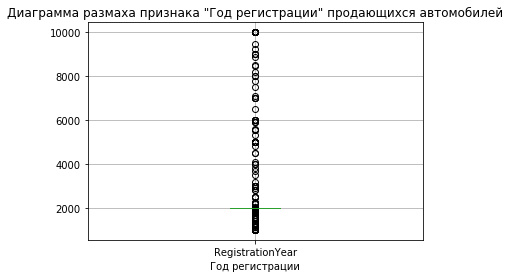

In [24]:
boxplot_auto('RegistrationYear', 'Год регистрации')

Очень интересно. Аномалии придется удалять.

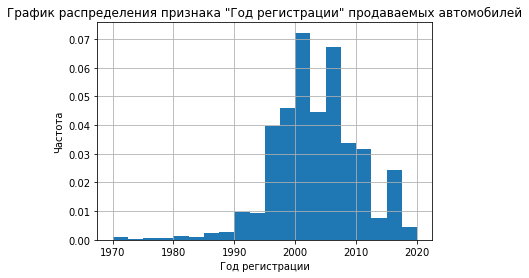

In [25]:
data.RegistrationYear.hist(range=(1970, 2020), bins=20, density=True)
plt.xlabel('Год регистрации')
plt.ylabel('Частота')
plt.title('График распределения признака "Год регистрации" продаваемых автомобилей')
plt.show()

Кто-то и в будущем машину зарегистрировал.

In [26]:
data.RegistrationMonth.value_counts()

0     37352
3     34373
6     31508
4     29270
5     29153
7     27213
10    26099
12    24289
11    24186
9     23813
1     23219
8     22627
2     21267
Name: RegistrationMonth, dtype: int64

Нулевой месяц радует. Ну судя по всему - это значение ставили автовладельцы, которые не знают месяц регистрации. Столбец не сильно много информации несет - вероятно, он будет удален. И нулевой месяц вместе с ним.

**Power**

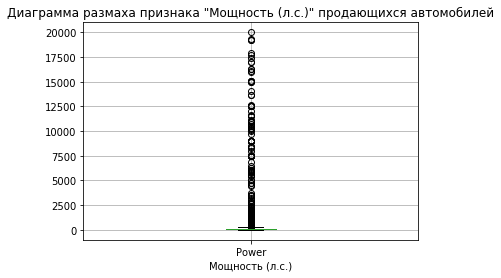

In [27]:
boxplot_auto('Power', 'Мощность (л.с.)')

Казалось бы, ничего необычного, если не узнать по первой ссылке в поисковике, что больше тысячи л.с. не бывает.

Аномалии будем удалять.

**Kilometer**

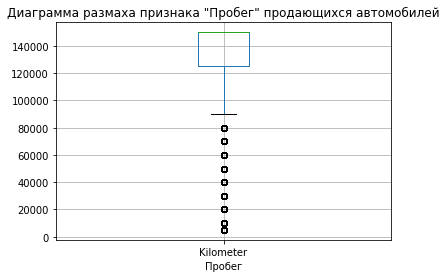

In [28]:
boxplot_auto('Kilometer', 'Пробег')

Вроде, неплохо.

**PostalCode**

In [29]:
data.PostalCode.nunique()

8143

Итак, у нас 8143 уникальных почтовых индекса. Что они дают? При желании можно вытащить из них город, если брать в пример Россию - тут цена в Екатеринбурге и Москве на машины, вероятно, разная. Но, неизвестно, что это за страна (вообще, скорее всего - Германия), ну и непонятно - стоит ли оно того, признак подает совсем мало надежд на помощь в качественном предсказании. Здравый смысл говорит о том, что его стоит удалить.

**Price**

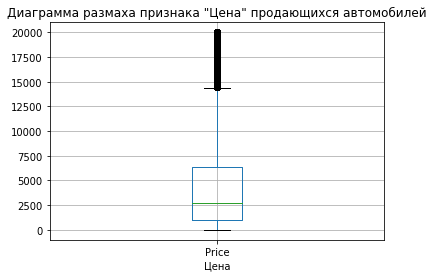

In [30]:
boxplot_auto('Price', 'Цена')

Ну вообще, 20 тыс. евро не так много, больше смущают нули. Попробуем без них.

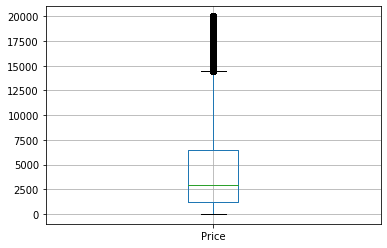

In [31]:
data[data.Price != 0].boxplot(column='Price')

Уже лучше, но все равно средняя цена смущает. Слишком мало. Разберемся позднее подробнее, это целевой признак, как никак.

**Вывод по Шагу 2**: итак, на данном шаге мы провели небольшой исследовательский анализ наших данных, что можно сказать - часть столбцов точно пойдет на удаление, почти все остальные столбцы содержат аномомалии или некорректные значения.Будем удалять, разбираться.

<h3>Шаг 3:Предобработка данных</h3>
<a id='preproc'></a>

In [32]:
'Размер датасета: {}'.format(data.shape[0])

'Размер датасета: 354369'

In [33]:
'Десять процентов от него : {}'.format(data.shape[0] // 10)

'Десять процентов от него : 35436'

Попробуем удалить не больше десяти процентов. Конечно, данных у нас достаточно, но все равно - чем больше, тем ведь лучше.

**Работа с признаками, несущими мало информации**

Начнем с удаления бесполезных столбцов, но перед этим - как и было написано выше, попробуем извлечь пользу из полей с датой.

Создадим новый признак и удалим аномалии по нему.

In [34]:
data['daysReg'] = (data.LastSeen - data.DateCreated).dt.days

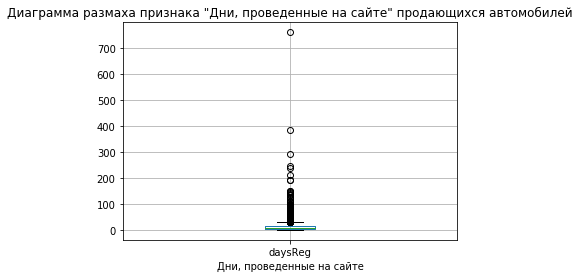

In [35]:
boxplot_auto('daysReg', 'Дни, проведенные на сайте')

In [36]:
data.daysReg.describe()

count    354369.000000
mean          8.677974
std           8.639404
min           0.000000
25%           2.000000
50%           6.000000
75%          13.000000
max         759.000000
Name: daysReg, dtype: float64

In [37]:
def hist_auto(col, r1, r2, bins, name):
    data[col].hist(bins=bins, density=True, range=(r1,r2))
    plt.xlabel(name)
    plt.ylabel('Частота')
    plt.title('Распределение частот значений признака "{}" продающихся автомобилей'.format(name))
    plt.show()

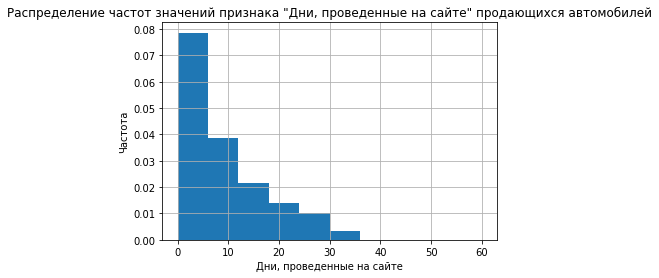

In [38]:
hist_auto('daysReg', 0, 60, 10, 'Дни, проведенные на сайте')

Ограничимся 40 днями. Хотя по диаграмме размаха, можно было удалить все объявления, где признак принимает значения от, примерно, 30. Но объективно - 40 дней продавать авто - это не страшно.

In [39]:
data = data.drop(index=data[data.daysReg > 40].index)

Теперь удалим остальные признаки, ожидаемая польза от которых либо равно нулю, либо совсем мала. Мы отмечали их выше.

In [40]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen', 'daysReg'],
      dtype='object')

In [41]:
data = data.drop(
    columns=['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'daysReg'])

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354120 entries, 0 to 354368
Data columns (total 10 columns):
Price               354120 non-null int64
VehicleType         316655 non-null object
RegistrationYear    354120 non-null int64
Gearbox             334298 non-null object
Power               354120 non-null int64
Model               334431 non-null object
Kilometer           354120 non-null int64
FuelType            321246 non-null object
Brand               354120 non-null object
NotRepaired         283007 non-null object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


Теперь столбцы отдельно.

**RegistrationYear**

In [43]:
data[data.RegistrationYear > 2016].shape[0]

14525

14 тысяч объявлений из будущего. Ну, это точно следует удалить. Данные значения некорректны.

In [44]:
data = data.drop(index=data[data.RegistrationYear > 2016].index)

Удалим другие очевидные ошибочные значения - ниже 1900 года.

In [45]:
data[data.RegistrationYear < 1900].shape[0]

66

In [46]:
data = data.drop(index=data[data.RegistrationYear < 1900].index)

Посмотрим, что с остальными раритетными объявлениями.

In [47]:
data.RegistrationYear.describe()

count    339529.000000
mean       2002.481408
std           7.090568
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

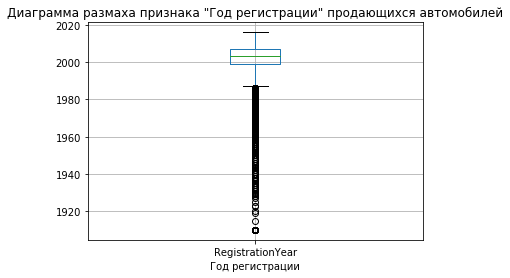

In [48]:
boxplot_auto('RegistrationYear', 'Год регистрации')

Ситуация спорная в том смысле, что мы не можем утверждать, что данные значения (с 1910 по 1980, например) ошибочны. 1910 год был не так давно! Но, даже если это не ошибки, то это аномалии в контексте построения модели для определения цены современного (а таких продается подавляющее большинство, очевидно) автомобиля. Ну и определение нижней границы, по которой аномалии стоит удалять, тоже спорный вопрос. Удалим пока до 1970. Дальше посмотрим на процент раритетных автомобилей.

In [49]:
data[data.RegistrationYear < 1970].shape[0] 

1272

In [50]:
data = data.drop(index=data[data.RegistrationYear < 1970].index)

In [51]:
def proc_check(year1, year2):
    res = 'Процент автомобилей, которые были зарегистрированы c {} до {} : {:.2%}'.format(year1, year2, 
    data[(data.RegistrationYear >= year1) & (data.RegistrationYear < year2)].shape[0] / data.shape[0])
    print(res)

In [52]:
proc_check(1910, 1980)
proc_check(1980, 1990)
proc_check(1990, 2000)

Процент автомобилей, которые были зарегистрированы c 1910 до 1980 : 0.62%
Процент автомобилей, которые были зарегистрированы c 1980 до 1990 : 1.83%
Процент автомобилей, которые были зарегистрированы c 1990 до 2000 : 27.36%


Ощутимый процент в объявлениях имеют лишь автомобили, зарегистрированные после 1990 года. Все, что было ДО, удалим тоже.

In [53]:
data = data.drop(index=data[data.RegistrationYear < 1990].index)

Посмотрим теперь на распределение признака.

Год регистрации автомобиля имеет существенное значение на цену автомобиля - это диктуется характером самой проблемы, это очевидно. Поэтому все аномальные и некорректные значения стоит удалять, этот признак очень важен.

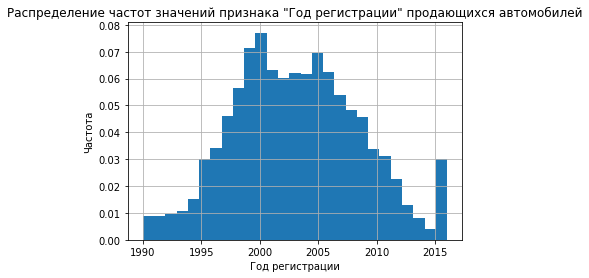

In [54]:
hist_auto('RegistrationYear', 1990, 2016, 27, 'Год регистрации')

Очень интересно, о чем повествует пик около 2016 года? Ведь в 2016 году только собирали эти данные. Причем в первый месяц весны - третий месяц (!) года. Как за два месяца столько машин уже прошло регистрацию, и одновременно понадобилось их столько продать. К тому же - у нас распределение почти нормальное (корзины взять пошире и вообще супер будет), так что этот пик выглядит сильно подозрительно. Глянем ближе.

In [55]:
data[data.RegistrationYear == 2016].head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
16,300,NaN,2016,NaN,60,polo,150000,petrol,volkswagen,NaN
31,899,NaN,2016,manual,60,clio,150000,petrol,renault,NaN
35,350,NaN,2016,manual,75,golf,150000,petrol,volkswagen,no
37,1500,NaN,2016,NaN,0,kangoo,150000,gasoline,renault,no
52,1400,NaN,2016,manual,55,other,5000,NaN,hyundai,NaN


Пробег 150000 км как бы намекает. Если зарегистрировать машину в 2016 году, 1 января, и разместить объявление 1 апреля, то для пробега в 150к км надо 20 раз в день объезжать ЕКАД. Естественно, каждый день.

In [56]:
data[data.RegistrationYear == 2016].Kilometer.mean()

133784.64263388206

Мы явно имеем дело с некорректными значениями. Посмотрим, сколько таких строк.

In [57]:
data[data.RegistrationYear == 2016].shape[0]

9598

Много. Посмотрим, получше.

In [58]:
data[data.RegistrationYear == 2016].Kilometer.value_counts()

150000    7414
125000     738
5000       395
100000     282
90000      192
80000      145
70000      107
60000       92
20000       69
30000       55
50000       53
40000       47
10000        9
Name: Kilometer, dtype: int64

Очень интересно. Итак, для машин зарегистрированных в 2016 мы имеем массу автомобилей с завышенным пробегом: даже зарегистрировав авто 1 января 2016, сложно было бы столько проехать. Оставим только объявления, где пробег не превышает 10000 км. Хотя это тоже много, конечно, но уже более реально.

In [59]:
data = data.drop(index=data[(data.RegistrationYear == 2016) & (data.Kilometer > 10000)].index)

Проверим распределение.

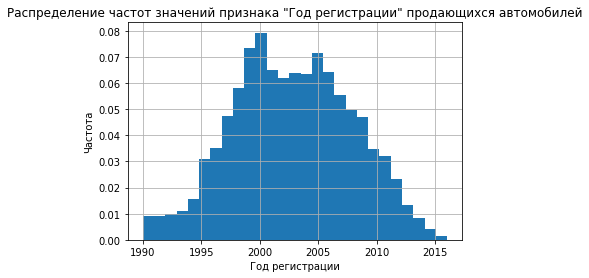

In [60]:
hist_auto('RegistrationYear', 1990, 2016, 27, 'Год регистрации')

Получилось как надо. 

**Power**

Уже ранее отмечалось, что в этом столбце ТОЧНО есть аномалии и некорректные значения. Разберемся.

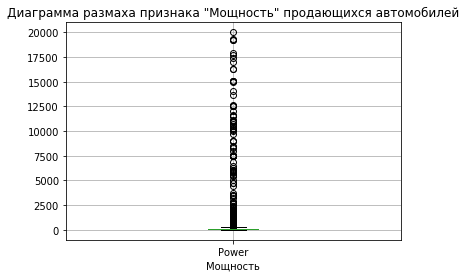

In [61]:
boxplot_auto('Power', 'Мощность')

Сразу удалим значения равные 0 и выше 1000 - они точно ошибочны. Дальше будем разбираться. 

In [62]:
data = data.drop(index=data[(data.Power >=1000) | (data.Power == 0)].index)

Посмотрим.

In [63]:
data.Power.describe()

count    289056.000000
mean        121.468996
std          54.630514
min           1.000000
25%          79.000000
50%         114.000000
75%         150.000000
max         999.000000
Name: Power, dtype: float64

Итак, небольшое расследование по поводу лошадиных сил у машины дало: машины с л.с. в диапазоне от 20 до 50 встречаются, но ощутимо реже, ниже 20 не удалось найти ничего практически; выше 700 л.с. тоже не было обнаружено ничего, а машины, л.с. которых лежат в диапазоне от 500 до 700 являются существенно дорогими и также редкими.

Удалим объявления с Power меньше 20 и выше 500 - как аномальные. Посмотрим еще раз на диаграмму размаха, также построим гистаграмму.

In [64]:
data = data.drop(index=data[(data.Power >= 500) | (data.Power <= 20)].index)

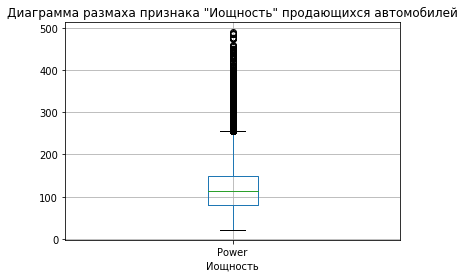

In [65]:
boxplot_auto('Power', 'Иощность')

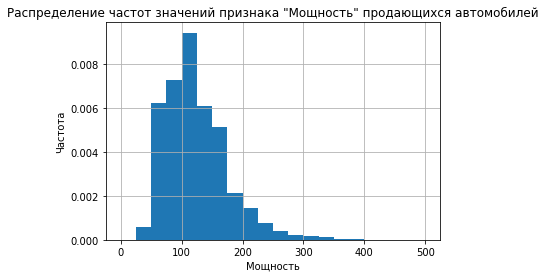

In [66]:
hist_auto('Power', 0,  500, 20, 'Мощность')

'Хвост' после 250 также можно убрать - аномалии.

In [67]:
data = data.drop(index=data[data.Power >= 250].index)

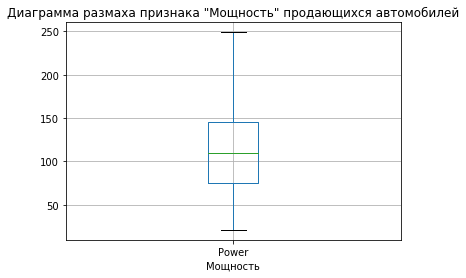

In [68]:
boxplot_auto('Power', 'Мощность')

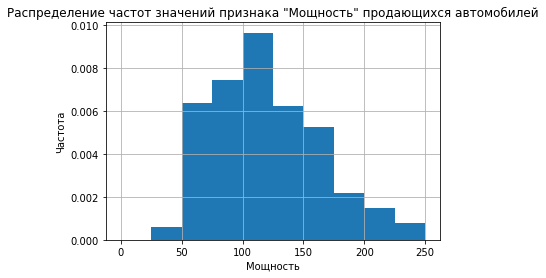

In [69]:
hist_auto('Power', 0,  250, 10, 'Мощность')

Все выглядит замечательно.

**Price**

Мы отмечали, что здесь есть объекты с ценой, равной нулю. Это нам не подходит, как и другие символические цены. Надо найти границу, по которой цена уже не считается таковой.

Построим гистограмму для цен - от 0 до 200.

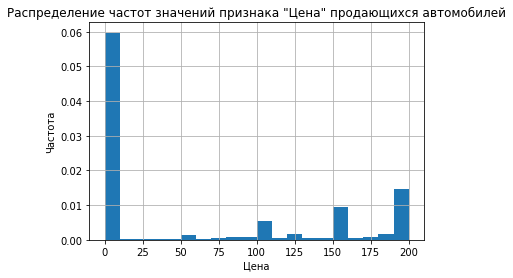

In [70]:
hist_auto('Price', 0,  200, 20, 'Цена')

Можно прикинуть, что около нуля - символические цены, а затем - с 50 евро, начинаются реальные цены, поскольку с данного значения наблюдается некоторая тенденция - рост пиков около 'круглых' значений и рост кол-ва объектов с ценами, значения которых между ними - 'круглыми'.

Определим символические цены как цены, значения которых ниже 50 евро. Удалим такие объекты.

In [71]:
data = data.drop(index=data[data.Price < 50].index).reset_index(drop=True)

Теперь посмотрим на завышенные значения. Имеются ли таковые вообще?

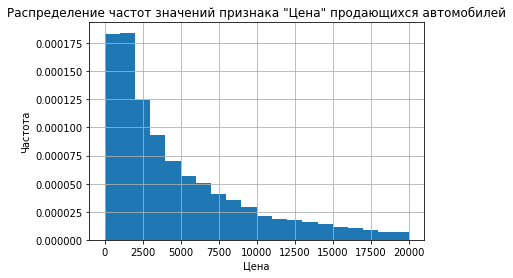

In [72]:
hist_auto('Price', 0,  20000, 20, 'Цена')

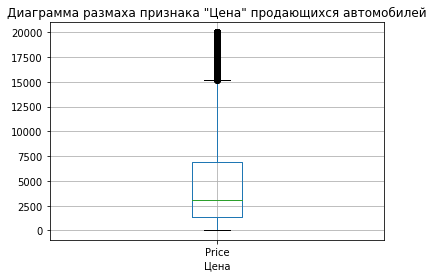

In [73]:
boxplot_auto('Price', 'Цена')

Диаграмма размаха говорит, что аномальные значения существуют, но гистограмма выглядит хорошо - явного 'хвоста' нет, а учитывая, сколько объектов мы уже удалили, точно стоит принять решение оставить все здесь как есть.

**Kilometer**

Мы уже встречались со значениями данного столбца, когда разбирались с годом регистрации. 

Построим гистаграмму.

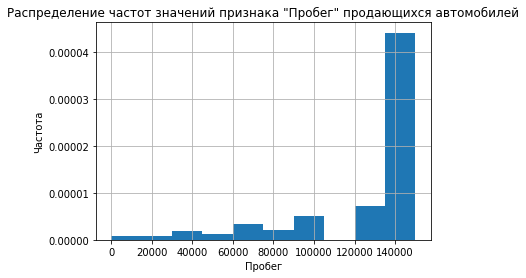

In [74]:
hist_auto('Kilometer', 0,  150000, 10, 'Пробег')

Видим тоже самое - много значений около максимума. Возможно, большее количество нельзя было указывать при заполнении анкеты, поэтому у всех машин, у которых пробег выше 150 тыс. км стоит такой. Если машина не была куплена (зарегистрирована) совсем недавно, то такое значение совсем не вызывает подозрений, так что в целом - аномалий здесь не наблюдается.

*Промежуточный вывод*: итак, мы удалили аномалии и некорректные значения в столбцах с численными признаками. В столбцах с категориальными признаками не было замечено ничего необычного на этапе исследовательского анализа, так что переходим к другим проблемам.

**Пропущенные значения**

Посмотрим на пропуски получше.

In [75]:
data.isnull().sum()

Price                   0
VehicleType          4499
RegistrationYear        0
Gearbox              4556
Power                   0
Model                8878
Kilometer               0
FuelType            12156
Brand                   0
NotRepaired         37798
dtype: int64

Итак, у нас пять столбцов с пропусками. 

Начнем с NotRepaired. Здесь у нас два варианта ответов:

In [76]:
data.NotRepaired.value_counts()

no     210791
yes     26610
Name: NotRepaired, dtype: int64

Если не указано, была ли машина в ремонте, более логично считать это как ответ 'Нет'. Заменим.

In [77]:
data = data.fillna({'NotRepaired':'no'})

Значения в Gearbox, VehicleType и FuelType можно восстановить, опираясь на значения в столбцах Brand и Model или на значения и в других столбцах, в общем - можно воспользоваться тем, что в базе могут быть идентичные автомобили. 

Для этого можно было бы построить отдельные модели, но мы не будем этого делать. 

Удалим строки, в которых отсутствуют значения и в Model и в VehicleType, поскольку первое можно примерно определить по второму, а второе точно узнать по первому, а вот объявление, в котором отсутствуют оба значения представляет собой мало ценности.

In [78]:
data = data.drop(index=data[(data['VehicleType'].isna() & (data['Model'].isna()))].index)

Напишем функцию для более удобного заполнения пропусков.

In [79]:
def filler(data, col_tof, col_touse1, col_touse2):
    fill_indx = data[data[col_tof].isna()].index
    for i in fill_indx:
        current1 = data.loc[i][col_touse1]
        current2 = data.loc[i][col_touse2]
        current_list = data[(data[col_touse1] == current1) & (
            data[col_touse2] == current2)][col_tof].value_counts()
        if len(current_list) != 0:
            filler = current_list.index[0]
        else:
            filler = np.nan
        data.loc[i, col_tof] = filler

Поверим работу функции.

In [80]:
data_test = data.loc[:500]

In [81]:
data_test[data_test['VehicleType'].isna()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
36,1400,NaN,2016,manual,55,other,5000,NaN,hyundai,no
47,2300,NaN,1997,manual,150,5er,150000,NaN,bmw,no
53,800,NaN,2000,manual,90,golf,150000,gasoline,volkswagen,no
64,250,NaN,2000,NaN,60,ka,150000,NaN,ford,no
77,900,NaN,1995,manual,90,civic,150000,petrol,honda,no
168,3750,NaN,2005,NaN,75,golf,150000,NaN,volkswagen,no
415,200,NaN,1995,manual,55,golf,150000,petrol,volkswagen,no
484,10100,NaN,2009,auto,143,1er,150000,NaN,bmw,no


In [82]:
filler(data_test, 'VehicleType', 'Model', 'Brand')

In [83]:
data_test[data_test['VehicleType'].isna()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
36,1400,NaN,2016,manual,55,other,5000,NaN,hyundai,no


Заполним пропуски во всех трех столбцах.

In [84]:
filler(data, 'VehicleType', 'Model', 'Brand')

In [85]:
filler(data, 'Model', 'VehicleType', 'Brand')

In [86]:
filler(data, 'Gearbox', 'Model', 'Brand')

In [87]:
filler(data, 'FuelType', 'Model', 'Brand')

Посмотрим, сколько пропусков осталось теперь.

In [88]:
data.isnull().sum()

Price                 0
VehicleType           0
RegistrationYear      0
Gearbox              19
Power                 0
Model               865
Kilometer             0
FuelType             36
Brand                 0
NotRepaired           0
dtype: int64

Оставшиеся пропуски это то, что не удалось заполнить. Удалим их.

In [89]:
data = data.dropna().reset_index(drop=True)

Посмотрим общую информацию о наших данных после процедур удаления аномалий и пропусков.

In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273625 entries, 0 to 273624
Data columns (total 10 columns):
Price               273625 non-null int64
VehicleType         273625 non-null object
RegistrationYear    273625 non-null int64
Gearbox             273625 non-null object
Power               273625 non-null int64
Model               273625 non-null object
Kilometer           273625 non-null int64
FuelType            273625 non-null object
Brand               273625 non-null object
NotRepaired         273625 non-null object
dtypes: int64(4), object(6)
memory usage: 20.9+ MB


Итак, это то, что мы будем использовать для обучения наших моделей.

**Вывод по Шагу 3**: итак, на данном шаге мы проделали коллосальную работу - мы удалили аномалии во всех столбцах с численными признаками, удалили те признаки, что несут в себе мало информации; также мы заполнили пропуски - в целом, мы провели предобработку данных, которая позволит нам построить более качественную модель.

<h3>Шаг 4: Обучение моделей</h3>
<a id='models'></a>

Переходим к основной части. К моделям. Определим алгоритмы, с которыми будем экспериментировать.

Это: случайный лес, обычная линейная регрессия, гребневая регрессия, регрессия со стохастическим градиентным спуском, k ближайших соседей, а также - алгоритм градиентного бустинга.

Метрика качества - rmse, также нам надо будет замерять время обучения моделей и время предсказания.

**Подготовка признаков**

По поводу признаков. Очевидно - необходимо их подготовить, избавиться от столбцов типа object как минимум. Но, подготовим данные для деревянных моделей - случайного леса и градиентного бустинга из LightGBM и остальных - трех видов регрессий и ближайших соседей по-разному. Общий план такой:

    - численные признаки стандартизировать для обоих вариантов; 
    - категориальные признаки: 
            + для деревянных моделей - использовать Ordinal Encoder, 
            + для регрессий и knn - использовать One Hot Encoding. 

Мы начнем с OHE и Ordinal Encoder, поскольку для этого необходим весь датасет, а дня стандартизации - уже требуется деление на тестовую и обучающую выборки.

Перед этим - копируем датасет. Нам необходимо два его варианта по очевидным причинам. Также - отделим целевой признак.

In [91]:
target = data['Price']
features = data.drop(columns=['Price'])
features_tree = deepcopy(features)

*One Hot Encoding*

Приступим к OHE.

In [92]:
features = pd.get_dummies(features, drop_first=True)

In [93]:
features.shape

(273625, 301)

Готово.

*Ordinal Encoder*

Теперь поменяем данные для деревянных моделей.

In [94]:
features_tree.columns

Index(['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'NotRepaired'],
      dtype='object')

In [95]:
objs = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [96]:
enc = OrdinalEncoder()
features_tree[objs] = enc.fit_transform(features_tree[objs])

In [97]:
features_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273625 entries, 0 to 273624
Data columns (total 9 columns):
VehicleType         273625 non-null float64
RegistrationYear    273625 non-null int64
Gearbox             273625 non-null float64
Power               273625 non-null int64
Model               273625 non-null float64
Kilometer           273625 non-null int64
FuelType            273625 non-null float64
Brand               273625 non-null float64
NotRepaired         273625 non-null float64
dtypes: float64(6), int64(3)
memory usage: 18.8 MB


Готово.

Продолжим делением на выборки - оно будет общим для всех моделей. Разобьем данные на обучающую, валидационную и тестовую выборки - в соотношении 6:2:2.

*Деление на выборки*

In [98]:
target_train, target_test, features_train, features_test, features_tree_train, features_tree_test = train_test_split(
    target, features, features_tree, test_size=0.2, random_state=12345)

In [99]:
target_train, target_valid, features_train, features_valid, features_tree_train, features_tree_valid = train_test_split(
    target_train, features_train, features_tree_train, test_size=0.25, random_state=12345)

*Стандартизируем численные признаки.*

Вспоминаем - StandardScaler учится на обучающей выборке, а применяется и к обучающей, и к валидационной и к тестовой.

Создадим список столбцов с численными признаками.

In [100]:
numbers = ['RegistrationYear', 'Power', 'Kilometer']

Обучим и трансформируем.

In [101]:
scaler = StandardScaler()
scaler.fit(features_train[numbers])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [102]:
features_train[numbers] = scaler.transform(features_train[numbers])
features_test[numbers] = scaler.transform(features_test[numbers])
features_tree_train[numbers] = scaler.transform(features_tree_train[numbers])
features_tree_test[numbers] = scaler.transform(features_tree_test[numbers])
features_valid[numbers] = scaler.transform(features_valid[numbers])
features_tree_valid[numbers] = scaler.transform(features_tree_valid[numbers])

На данный момент в наших руках 8 различных выборок:

    - с целевым признаком: 
        + target_train - обучающая
        + target_test - тестовая
    - с признаками: 
        + features_tree_train 
        + features_train - обучающие
        + features_tree_test
        + features_test - тестовые
        + features_tree_valid
        + features_valid - валидационные

Приступим к обучению.

Время обучения, предсказания и RMSE на валидационной выборке будем записывать в датафрейм.

In [103]:
conclusion = pd.DataFrame(columns=['name', 'fit_time (s)', 'predict_time(s)', 'rmse'])

**Линейная регрессия**

Начнем с самого простого - обычной линейной регрессии. Обучим модель, проверим качество и время обучения.

In [104]:
%%time
model1 = LinearRegression()
model1.fit(features_train, target_train)

Wall time: 4.82 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

*Время обучения: 3,5 с.* Теперь посмотрим на качество.

In [105]:
def metr(model):
    predicted_tr = model.predict(features_train)
    predicted_v = model.predict(features_valid)
    rmse_tr = round(mean_squared_error(predicted_tr, target_train) ** 0.5,0)
    rmse_v = round(mean_squared_error(predicted_v, target_valid) ** 0.5,0)
    print('RMSE на тренировочной выборке: {}'.format(rmse_tr))
    print('RMSE на валидационной выборке: {}'.format(rmse_v))
    print('R2 на тренировочной выборке: {:.2}'.format(model.score(features_train, target_train)))
    print('R2 на валидационной выборке: {:.2}'.format(model.score(features_valid, target_valid)))

In [106]:
metr(model1)

RMSE на тренировочной выборке: 2145.0
RMSE на валидационной выборке: 2164.0
R2 на тренировочной выборке: 0.77
R2 на валидационной выборке: 0.77


Время предсказания.

In [107]:
%%time
model1.predict(features_valid.iloc[0:1])

Wall time: 2.99 ms


array([4262.62434999])

997 микросекунд, это 1 миллисекунда или 0,001 секунды.

In [108]:
conclusion.loc[0] = ['linear regression', 3.5, 0.001, 2164]

Неплохо, идем дальше - на очереди гребневая регрессия - Ridge.

**Гребневая регрессия**

Здесь мы будем подбирать параметры, поэтому воспользуемся GridSearchCV, соберем в обучающую выборку обучающую и валидационную выборки.

In [109]:
features_train1 = pd.concat([features_train, features_valid])
target_train1 = pd.concat([target_train, target_valid])

Посмотрим, какие результаты показывает модель при разном значении параметра регуляризации альфа.

In [110]:
model2gs = Ridge()
params2 = {'alpha': [0.1, 0.5, 0.75, 1, 2, 5, 10, 15]}
gs2 = GridSearchCV(model2gs, params2, cv=5, n_jobs=-1)

In [111]:
gs2.fit(features_train1, target_train1)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.1, 0.5, 0.75, 1, 2, 5, 10, 15]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [112]:
gs2.best_params_

{'alpha': 0.5}

Получили альфа 0.5. Теперь обучим модель.

In [113]:
%%time
model2 = Ridge(alpha=0.5, random_state=12345)
model2.fit(features_train, target_train)

Wall time: 1.19 s


Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=12345, solver='auto', tol=0.001)

*Время обучения: 0.86 c.*

In [114]:
metr(model2)

RMSE на тренировочной выборке: 2145.0
RMSE на валидационной выборке: 2164.0
R2 на тренировочной выборке: 0.77
R2 на валидационной выборке: 0.77


Получили такое же качество, зато выиграли во времени обучения.

In [115]:
%%time
model2.predict(features_valid.iloc[0:1])

Wall time: 3.99 ms


array([4262.23133559])

Время предсказания 0,001 cекунда.

In [116]:
conclusion.loc[1] = ['ridge regression', 0.86 , 0.001, 2164]

Теперь линейная регрессия со стохастическим градиентным спуском.

**SGD regression**

Здесь будем также менять альфа.

In [117]:
model3gs = SGDRegressor()
params3 = {'alpha': [0.0001, 0.001, 0.1, 0.5, 0.75, 1, 2]}
gs3 = GridSearchCV(model3gs, params3, cv=5, n_jobs=-1)

In [118]:
gs3.fit(features_train1, target_train1)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SGDRegressor(alpha=0.0001, average=False,
                                    early_stopping=False, epsilon=0.1,
                                    eta0=0.01, fit_intercept=True,
                                    l1_ratio=0.15, learning_rate='invscaling',
                                    loss='squared_loss', max_iter=1000,
                                    n_iter_no_change=5, penalty='l2',
                                    power_t=0.25, random_state=None,
                                    shuffle=True, tol=0.001,
                                    validation_fraction=0.1, verbose=0,
                                    warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.1, 0.5, 0.75, 1, 2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [119]:
gs3.best_params_

{'alpha': 0.0001}

Получили альфа. Теперь обучим модель.

In [120]:
%%time
model3 = SGDRegressor(alpha=0.0001, random_state=12345)
model3.fit(features_train, target_train)

Wall time: 51.2 s


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=12345,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

*Время обучения: 24,6 секунд* 

In [121]:
metr(model3)

RMSE на тренировочной выборке: 2154.0
RMSE на валидационной выборке: 2172.0
R2 на тренировочной выборке: 0.77
R2 на валидационной выборке: 0.77


Качество модели не улучшилось, зато время обучения сильно выросло. Врядли мы будем использовать эту модель.

In [122]:
%%time
model3.predict(features_valid.iloc[0:1])

Wall time: 1.99 ms


array([4227.59238577])

Время предсказания: 2 мс, это 0,002 секунды.

In [123]:
conclusion.loc[2] = ['sgd regression', 24.6, 0.002, 2172]

На этом с регрессиями все. Переходим к алгоритму k ближайших соседей.

**K ближайших соседей**

Обучим модель.

In [124]:
%%time
model4 = KNeighborsRegressor(weights='distance', n_neighbors=9)
model4.fit(features_train, target_train)

Wall time: 25.3 s


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                    weights='distance')

*Время обучения: 12, 7 с.* Теперь качество.

In [125]:
metr(model4)

RMSE на тренировочной выборке: 873.0
RMSE на валидационной выборке: 1526.0
R2 на тренировочной выборке: 0.96
R2 на валидационной выборке: 0.88


Время предсказания.

In [126]:
%%time
model4.predict(features_valid.iloc[0:1])

Wall time: 8.94 ms


array([2216.01452726])

Время предсказания 0,006 секунд.

In [127]:
conclusion.loc[3] = ['knn', 12.7, 0.006, 1526]

Качество у этой модели куда лучше, чем у регрессий, но время обучения и предсказания немалое.

На очереди случайный лес.

**Случайный лес**

Здесь и далее мы уже будем работать с другими выборками - теми, в названии которых есть слово 'tree'. Также будем использовать кросс-валидацию, поэтому - соединим выборку обратно.

In [128]:
features_tree_train1 = pd.concat([features_tree_train, features_tree_valid])
target_tree_train1 = pd.concat([target_train, target_valid])

Будем менять параметры: количество деревьев, максмальная глубина. 

In [129]:
model5gs = RandomForestRegressor()
params5 = {'max_depth' : [5, 10, 15, 20, 30, 40],
          'n_estimators' : [100, 200]}
gs5 = GridSearchCV(model5gs, params5, cv=4, n_jobs=-1)

In [130]:
gs5.fit(features_tree_train1, target_tree_train1)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20, 30, 

In [131]:
gs5.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Нашли лучшие параметры: 

In [132]:
%%time
model5 = RandomForestRegressor(max_depth=20, n_estimators=200, random_state=12345)
model5.fit(features_tree_train, target_train)

Wall time: 1min 3s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

*Время обучения модели:* 2 минуты и 9 секунд это 129 секунд.

In [133]:
%%time
model5.predict(features_tree_valid.iloc[0:1])

Wall time: 49.7 ms


array([1582.02060128])

*Время предсказания модели:* 26 секунд.

Посмотрим качество.

In [134]:
def metr_tree(model):
    predicted_tr = model.predict(features_tree_train)
    predicted_v = model.predict(features_tree_valid)
    rmse_tr = round(mean_squared_error(predicted_tr, target_train) ** 0.5,0)
    rmse_v = round(mean_squared_error(predicted_v, target_valid) ** 0.5,0)
    print('RMSE на тренировочной выборке: {}'.format(rmse_tr))
    print('RMSE на валидационной выборке: {}'.format(rmse_v))
    print('R2 на тренировочной выборке: {:.2}'.format(model.score(features_tree_train, target_train)))
    print('R2 на валидационной выборке: {:.2}'.format(model.score(features_tree_valid, target_valid)))

In [135]:
metr_tree(model5)

RMSE на тренировочной выборке: 967.0
RMSE на валидационной выборке: 1433.0
R2 на тренировочной выборке: 0.95
R2 на валидационной выборке: 0.9


In [136]:
conclusion.loc[4] = ['random forest', 129, 26, 1433]

Качество еще лучше, чем у алгоритма k ближайших соседей, зато время обучения и предсказания в несколько раз больше.

И наконец - градиентный бустинг.

**Градиентный бустинг**

Будем менять те же параметры, что и для случайного леса - максимальную глубину и количество деревьев.

In [137]:
model6gs = LGBMRegressor()
params6 = {'max_depth' : [5, 10, 15, 20, 30, 40],
          'n_estimators' : [100, 200]}
gs6 = GridSearchCV(model6gs, params6, cv=4, n_jobs=-1)

In [138]:
gs6.fit(features_tree_train1, target_tree_train1)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20, 30, 40],
                         'n_estimators': [100, 200]},
             pre_dispatch='2*n_jobs', refit=True, retur

In [139]:
gs6.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=20,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Лучшие параметры совпадают с теми, что были указаны для случайного леса.

In [140]:
%%time
model6 = LGBMRegressor(max_depth=20, n_estimators=200, random_state=12345)
model6.fit(features_tree_train, target_train)

Wall time: 1.48 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=20,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

*Время обучения: 813 мс*. Это 0,8 cекунд. Качество и скорость предсказания.

In [141]:
%%time
model6.predict(features_tree_valid.iloc[0:1])

Wall time: 8.98 ms


array([2133.3700475])

Время предсказания 0, 003 секунд.

In [142]:
metr_tree(model6)

RMSE на тренировочной выборке: 1420.0
RMSE на валидационной выборке: 1458.0
R2 на тренировочной выборке: 0.9
R2 на валидационной выборке: 0.89


Качество хорошее. С таким временем обучения - вообще сказка.

In [143]:
conclusion.loc[5] = ['gbm', 0.813, 0.003, 1462]

**Выводы по Шагу 4**: итак, на данном шаге мы обучили 6 различных моделей, перед этим подготовили признаки - привели их в тот вид, что могут принять модели; для каждой модели мы измерили время обучения, время предсказания и rmse на валидационной выборке, также для некоторых алгоритмов подбирали оптимальные гиперпараметры, что позволило получить еще лучшее качество.

<h3>Шаг 5: Выводы и выбор лучшией модели</h3>
<a id='test_sanity'></a>

Итак, в предыдущих четырех шагах данной работы мы проделали колоссальную работу. Осталось - сделать выводы, прокомментировать результаты и выбрать лучшую модель.

Посмотрим на показатели наших моделей.

In [144]:
conclusion

,name,fit_time (s),predict_time(s),rmse
0,linear regression,3.500,0.001,2164
1,ridge regression,0.860,0.001,2164
2,sgd regression,24.600,0.002,2172
3,knn,12.700,0.006,1526
4,random forest,129.000,26.000,1433
5,gbm,0.813,0.003,1462


Итак, что мы видим:

    - самая быстрая модель по обучению- градиентный бустинг и гребневая регрессия (как никак, она не сильно дальше ушла), 
    - самая качественная модель - случайный лес (плюс градиентный бустинг дышит в спину лидеру), 
    - самая быстрая модель по предсказанию - линейная и гребневая регрессии
    - самая неудачная модель - регрессия со стохастическим градиентным спуском - качество хуже, чем на двух других регрессиях, зато время обучения - в несколько раз выше

Очевидно, наша лучшая модель здесь - градиентный бустинг; Один из двух лидеров по качеству, а также самый быстрый алгоритм. Посмотрим на качество модели на тестовой выборке.

In [145]:
predicted_best = model5.predict(features_tree_test)

In [146]:
rmse = round(mean_squared_error(predicted_best, target_test) ** 0.5,0)
print('RMSE на тестовой выборке: {}'.format(rmse))
print('R2 на тестовой выборке: {:.2}'.format(model6.score(features_tree_test, target_test)))

RMSE на тестовой выборке: 1428.0
R2 на тестовой выборке: 0.89


Результат такой же хороший!

Давайте еще немного поговорим про остальные модели.

In [147]:
conclusion[:5]

,name,fit_time (s),predict_time(s),rmse
0,linear regression,3.50,0.001,2164
1,ridge regression,0.86,0.001,2164
2,sgd regression,24.60,0.002,2172
3,knn,12.70,0.006,1526
4,random forest,129.00,26.000,1433


Очевидную неудачу мы уже отметили - sgd больше не рассматриваем. Что с остальными? Будем ориентироваться на время обучения и rmse, отбросим время предсказания. Наши 4 модели условно поделились на два лагеря: быстро обучаются + качество среднее; дольше обучаются + качество хорошее. Если бы не было бустинга - нашего победителя, можно было бы дать такую рекомендацию: если в приоритете время обучения - надо брать гребневую регрессию, если качество - случайный лес, а если требуется оптимальное решение - компромисс - то knn: данная модель имеет качество почти как у леса, но обучается в несколько раз быстрее.

**Выводы по Шагу 5**: итак, на данном шаге мы прокомментировали результаты работы наших моделей - выбрали одну как лучшую, посмотрели на ее качество на тестовой выборке. Также посмотрели на остальные.